Joseph Bruno, Stacey Van, Vu Dinh

CMPE 255 Term Project / Group 2

## **Part 1: PEMS-SF Traffic Classification Model**
This notebook uses the **PEMS-SF Dataset** from the UCI Machine Learning Repository.

#### **Goal**  
Generate a day-of-week traffic classification model using a `RandomForestClassifier`.

#### **Process and Techniques**  
This project explored analysis of datasets, preprocessing, data mining, machine learning, evaluation, analysis, and generation of visuals.  

#### **Files Required**  
(See `README.md` for details)  
1. `PEMS-SF_model.ipynb`  
2. `PEMS_train.txt`  
3. `PEMS_trainlabels.txt`  
4. `PEMS_test.txt`  
5. `PEMS_testlabels.txt`

### **1. Import Python libraries**

In [296]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib

### **2. Clean and load datasets**
### **3. Explore dataset**
Note that pre-processing of dataset with incremental PCA was investigated. However, it was determined the PEMS_train dataset had been preprocessed and attempts further apply dimention reduction resulted in a lower F1-score.

Additionally, the given PEMS_test dataset was replaced with a dataset generated from the original PEMS_train dataset. This was to address confounding issues with the given PEMS_test dataset was significantly comprised if the exact datasets found in the training data. The test data allocated from the train data was removed from our PEMS_train dataset to address issues with the orignal test data.

In [298]:
def load_labels(file_path): # load and clean labels
    """
    1. Load labels with pandas. 
    2. Clean format: brackets, whitespace. 
    """
    df = pd.read_csv(file_path, header=None, sep=r'\s+')  # read the file as a single column 
    df = df.apply(lambda col: col.astype(str).str.replace('[', '', regex = False).str.replace(']', '', regex = False).str.strip())  # removes brackets, strip extra whitespace in columns

    labels = df.values.flatten().astype(int) # convert to integers
    return labels

# parse data files
def parse_pems_data(file_path):
    """
    1. Parse each line to show day's time-series data 
    2. Format: MATLAB matrix syntax
    """
    data = []
    with open(file_path, 'r') as file:
        for line in file: # convert MATLAB matrix syntax to NumPy array
            line = line.strip().replace('[', '').replace(']', '')
            rows = line.split(';')
            matrix = np.array([[float(x) for x in row.split()] for row in rows])
            data.append(matrix)
    return np.array(data)

train_file = "PEMS_train.txt"
test_file = "PEMS_test.txt"
train_label_file = "PEMS_trainlabels.txt"
test_label_file = "PEMS_testlabels.txt"

# parse
train_data = parse_pems_data(train_file)
test_data = parse_pems_data(test_file)

# load 
train_labels = load_labels(train_label_file)
test_labels = load_labels(test_label_file)
print("\033[1mDatasets Shape\033[0m")
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Datasets Shape
Train data shape: (246, 963, 144)
Test data shape: (18, 963, 144)
Train labels shape: (246,)
Test labels shape: (18,)


In [299]:
single_day_data = train_data[0] # selects a single day

time_intervals = [f"{hour:02d}:{minute:02d} {'AM' if hour < 12 else 'PM'}" # time intervals for columns
                  for hour in range(24)
                  for minute in range(0, 60, 10)]
                      
print("\033[1mSample of Sensor Information\033[0m\r") # title for output

# dataframe with sensor IDs = rows, time intervals = columns
sensor_ids = [f"Sensor {i + 1}" for i in range(single_day_data.shape[0])]
df = pd.DataFrame(single_day_data, index = sensor_ids, columns = time_intervals)
print(df.head())

Sample of Sensor Information
          00:00 AM  00:10 AM  00:20 AM  00:30 AM  00:40 AM  00:50 AM  \
Sensor 1    0.0154    0.0085    0.0099    0.0108    0.0100    0.0111   
Sensor 2    0.0054    0.0051    0.0056    0.0045    0.0037    0.0027   
Sensor 3    0.0164    0.0127    0.0172    0.0126    0.0185    0.0077   
Sensor 4    0.0079    0.0062    0.0068    0.0072    0.0048    0.0046   
Sensor 5    0.0059    0.0051    0.0053    0.0058    0.0063    0.0046   

          01:00 AM  01:10 AM  01:20 AM  01:30 AM  ...  22:20 PM  22:30 PM  \
Sensor 1    0.0099    0.0081    0.0099    0.0088  ...    0.0152    0.0182   
Sensor 2    0.0046    0.0028    0.0042    0.0040  ...    0.0191    0.0140   
Sensor 3    0.0119    0.0086    0.0091    0.0124  ...    0.0381    0.0348   
Sensor 4    0.0046    0.0046    0.0045    0.0057  ...    0.0171    0.0172   
Sensor 5    0.0063    0.0047    0.0052    0.0044  ...    0.0127    0.0140   

          22:40 PM  22:50 PM  23:00 PM  23:10 PM  23:20 PM  23:30 PM  \
Sen

### **4a. Generate Heatmap Visual of Average Traffic Based on Day-of-Week (10-min intervals)**

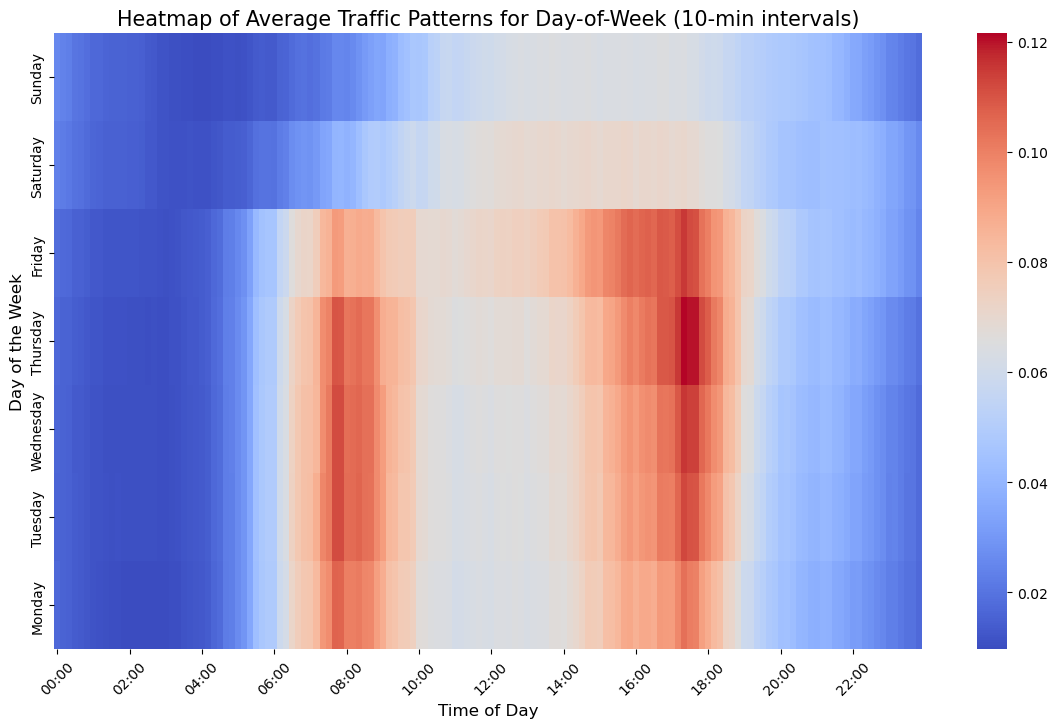

In [301]:
# aggregate data by avg. across sensors for each time interval - 10-MIN INTERVALS
def aggregate_data(data):
    """
    1. Aggregates traffic data by averaging across all sensors.
    2. Returns a dataframe with rows = days and columns = time intervals.
    """
    aggregated = np.mean(data, axis=1)
    return aggregated
    
# aggregate training data to visualize
aggregated_train_data = aggregate_data(train_data)

# reduce time intervals from 10-minute to 1-hour intervals
aggregated_train_data_hourly = aggregated_train_data.reshape(-1, 6).mean(axis = 1) # assume 144 intervals, 10-mins/24hrs
aggregated_train_data_hourly = aggregated_train_data_hourly.reshape(-1, 24)  # reshape back to days x hours

# DataFrame with labels
time_intervals = [f"{hour:02d}:{minute:02d}" for hour in range(24) for minute in range(0, 60, 10)]
df = pd.DataFrame(aggregated_train_data, columns = time_intervals)
df['Day'] = train_labels

# group by day of the week & calculate mean occupancy
day_names = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
df['Day'] = df['Day'].map(day_names)  # map numeric labels to day names
grouped = df.groupby('Day').mean()    # average overa all samples per day-of-week

# re-order day of week to display correctly for Heatmat (Sunday to Monday)
day_order = ['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']

# group dataframe to keep order sequence
grouped = grouped.reindex(day_order)

# heatmap and line trends (10-min intervals)
plt.figure(figsize = (14, 8))
sns.heatmap(grouped, cmap = 'coolwarm', cbar = True, xticklabels = 12, yticklabels = True)

# labels for heatmap
plt.title('Heatmap of Average Traffic Patterns for Day-of-Week (10-min intervals)', fontsize = 15)
plt.xlabel('Time of Day', fontsize = 12)
plt.ylabel('Day of the Week', fontsize = 12)
plt.xticks(rotation = 45, fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

### **4b. Generate Heatmap Visual of Average Traffic Based on Day-of-Week (1-hour interval)**

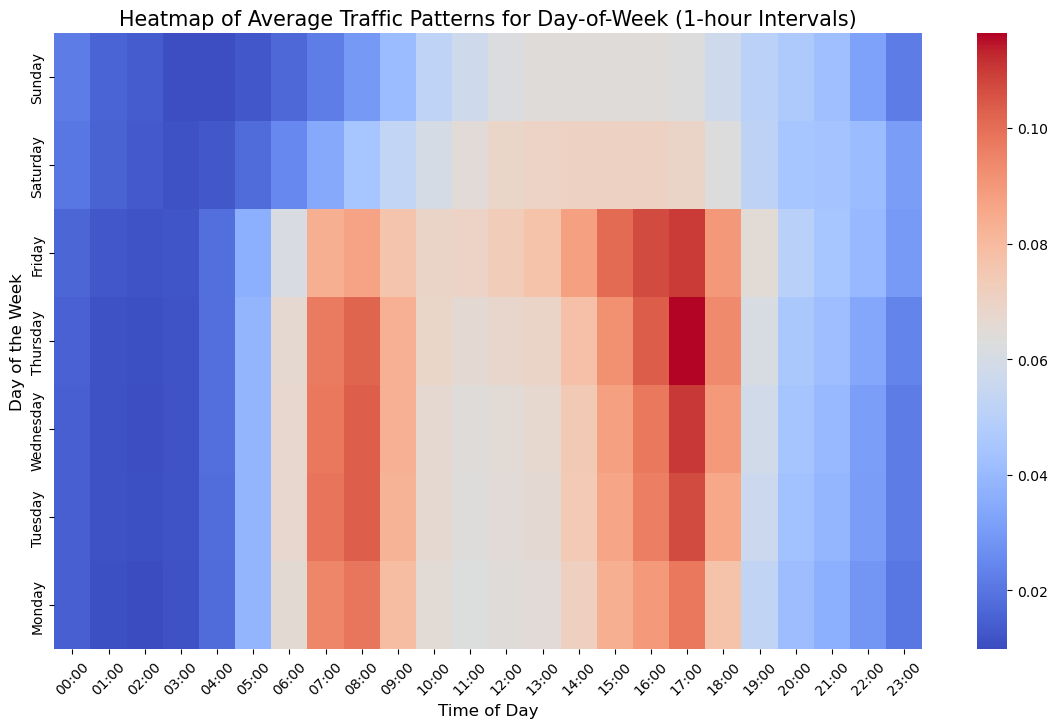

In [303]:
# aggregate data (average of all sensors based on time) - 1 HOUR INTERVAL
def aggregate_data(data):
    """
    1. Aggregates traffic data by averaging across all sensors.
    2. Returns a dataframe with rows = days and columns = time intervals.
    """
    aggregated = np.mean(data, axis=1)
    return aggregated

# aggregate training data 
aggregated_train_data = aggregate_data(train_data)

# reduce time intervals from 10-minute to 1-hour intervals
aggregated_train_data_hourly = aggregated_train_data.reshape(-1, 6).mean(axis = 1) # assume 144 intervals, 10-mins/24hrs
aggregated_train_data_hourly = aggregated_train_data_hourly.reshape(-1, 24)        # reshape back to days x hours

# time intervals with 1-hour increments
time_intervals = [f"{hour:02d}:00" for hour in range(24)]
df = pd.DataFrame(aggregated_train_data_hourly, columns = time_intervals)
df['Day'] = train_labels

# group by day of the week and calculate mean occupancy
day_names = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
df['Day'] = df['Day'].map(day_names)  # map number day labels to day name
grouped = df.groupby('Day').mean()    # average over all samples for each day

# re-order day of week for Heatmat to display in desired order for visual (Sunday to Monday)
day_order = ['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']

# group DataFrame to maintain order sequence
grouped = grouped.reindex(day_order)

# heatmap at intervals of 1-hour
plt.figure(figsize = (14, 8))
sns.heatmap(grouped, cmap = 'coolwarm', cbar = True, xticklabels = True, yticklabels = True)
plt.title('Heatmap of Average Traffic Patterns for Day-of-Week (1-hour Intervals)', fontsize = 15)
plt.xlabel('Time of Day', fontsize = 12)
plt.ylabel('Day of the Week', fontsize = 12)
plt.xticks(rotation = 45, fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

### **5. Generate Graph to Display Traffic Trends for each Day-of-Week (Time vs. Average Occupancy)**

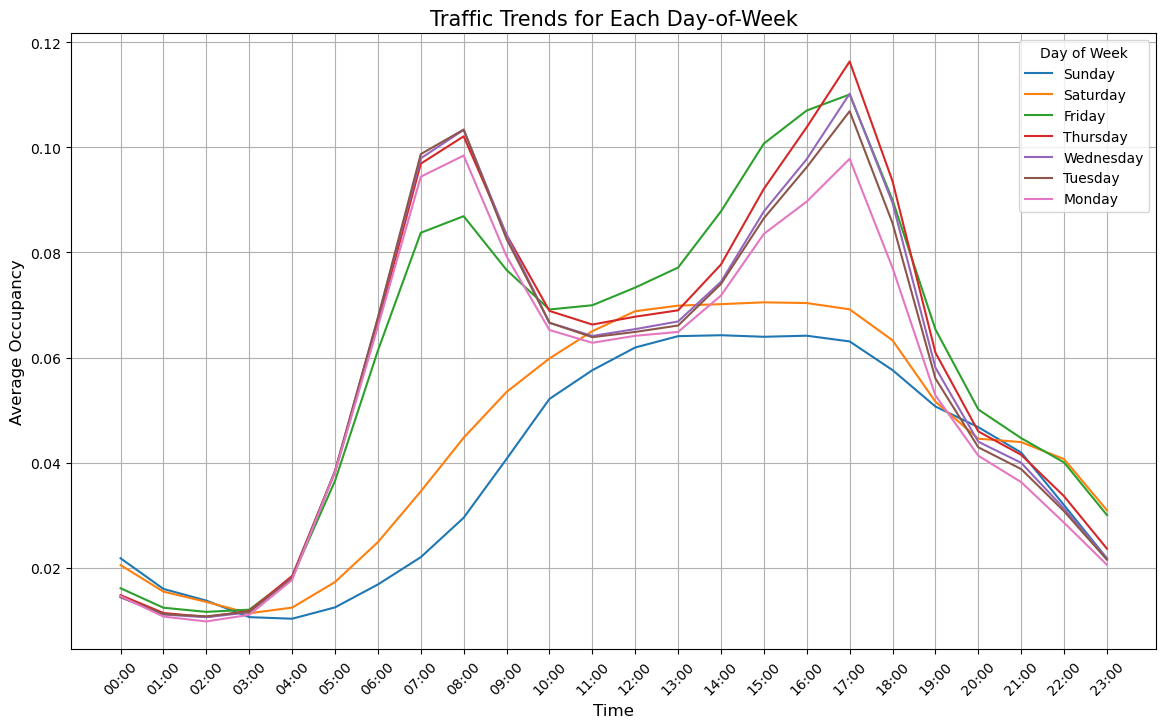

In [305]:
# graph to display average traffic trends for each day of week 
plt.figure(figsize = (14, 8))
for day in grouped.index:
    plt.plot(grouped.columns, grouped.loc[day], label = day)

plt.title('Traffic Trends for Each Day-of-Week', fontsize = 15)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Average Occupancy', fontsize = 12)

# update x-axis to 1-hour increments 
plt.xticks(ticks = range(len(grouped.columns)), labels = grouped.columns, rotation = 45, fontsize = 10)
plt.legend(title = 'Day of Week', fontsize = 10)
plt.grid(True)
plt.show()

### **6. Model training and hyperparameter tuning with training-validation** 

In [307]:
# Reference: decision_tree_evaluation activity cmpe 255
x_train, x_test, y_train, y_test = train_test_split(
    train_data.reshape(train_data.shape[0], -1), train_labels.ravel(), test_size = 0.2, random_state = 1, stratify = train_labels.ravel())

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# RandomForestClassifier with hyperparameter tuning (RandomizedSearchCV)
rf = RandomForestClassifier(random_state = 44)
param_distributions = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],     }

random_search = RandomizedSearchCV(rf, param_distributions, n_iter = 10, cv = 5, scoring = "accuracy", random_state = 44, n_jobs = -1)
random_search.fit(x_train, y_train)

# best parameters
best_params = random_search.best_params_
print("\nBest Parameters (RandomizedSearchCV):", best_params)

# train with best parameters
rf_best = random_search.best_estimator_
rf_best.fit(x_train, y_train)

x_train shape: (196, 138672)
x_test shape: (50, 138672)
y_train shape: (196,)
y_test shape: (50,)

Best Parameters (RandomizedSearchCV): {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10}


RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=400,
                       random_state=44)

## **7a. Results of baseline model** 

In [309]:
# prediction
y_pred = rf_best.predict(x_test)

# evaluate & classification report
print("F1 Score (Baseline):", accuracy_score(y_test, y_pred))
print("\nClassification Report (Baseline):\n", classification_report(y_test, y_pred))

F1 Score (Baseline): 0.96

Classification Report (Baseline):
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      0.67      0.80         6
           3       0.78      1.00      0.88         7
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         8

    accuracy                           0.96        50
   macro avg       0.97      0.95      0.95        50
weighted avg       0.97      0.96      0.96        50



### **7b. Save model**

In [311]:
# Save the model
joblib.dump(rf_best, 'random_forest_model.pkl')

# To load the model later
# loaded_model = joblib.load('best_random_forest_model.pkl')

['random_forest_model.pkl']

In [312]:
# To load the model
loaded_model = joblib.load('random_forest_model.pkl')

### **8. Analysis: Confusion Matrix for baseline/trained model**

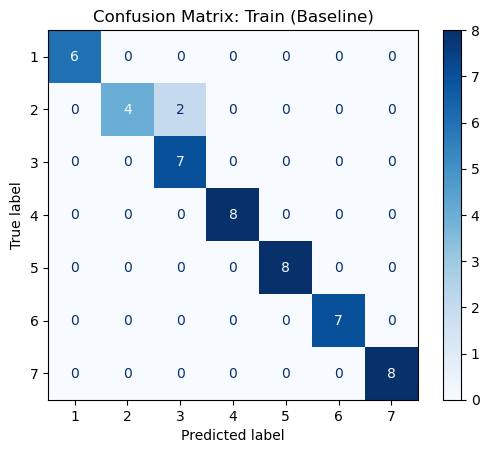

In [314]:
# Confusion Matrix - TRAINING DATASET (BASELINE)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(y_test))
disp.plot(cmap = plt.cm.Blues, values_format = 'd')
plt.title("Confusion Matrix: Train (Baseline)")
plt.show()

### **9. Classifier model evaluation with test dataset**

In [316]:
y_pred = rf_best.predict(test_data.reshape(test_data.shape[0], -1))
print("F1 Score (Test):", accuracy_score(test_labels, y_pred))
print("\nClassification Report (Test):\n", classification_report(test_labels, y_pred))

F1 Score (Test): 0.9444444444444444

Classification Report (Test):
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      0.75      0.86         4
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2

    accuracy                           0.94        18
   macro avg       0.95      0.96      0.95        18
weighted avg       0.96      0.94      0.95        18



### **9. Analysis of model with test dataset**

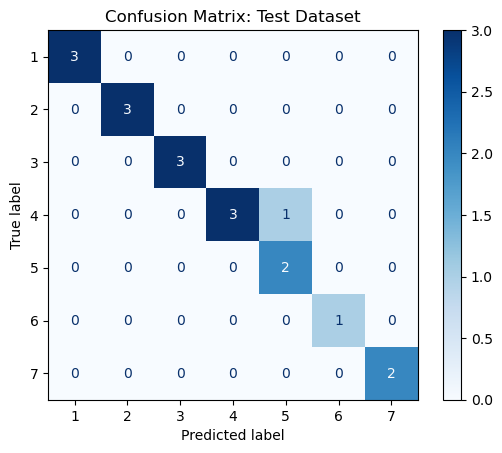

In [318]:
# Confusion Matrix - TEST DATASET
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(y_test))
disp.plot(cmap = plt.cm.Blues, values_format = 'd')
plt.title("Confusion Matrix: Test Dataset")
plt.show()

### **10. Visual for frequency of day-of-week distribution within training and test datasets**

In [320]:
# set-up barplot graph for class distribution (Training vs. Test Dataset)
def plot_class_distribution(labels, label_mapping = None, title = "Class Distribution", dataset_type = "Dataset"):
    unique, counts = np.unique(labels, return_counts = True)
    if label_mapping:
        unique = [label_mapping[label] for label in unique]
    
    # set-up for bargraph
    plt.figure(figsize = (8, 6))
    sns.barplot(     
        x = unique,
        y = counts,
        palette = "Blues",
        dodge = False,   # ensures barplot NOT grouped by hue (to address future update inorder to avoid error)
        legend = False)  # disables legend since hue is not assigned (address future update to avoid error)

    # labels for plot
    plt.title(f"{title} ({dataset_type} Set)", fontsize = 16)
    plt.xlabel("Class", fontsize = 12)
    plt.ylabel("Frequency", fontsize = 12)
    plt.xticks(rotation = 45)
    plt.grid(axis = "y", linestyle="--", alpha = 0.7)
    plt.show()

# print overview
print(f"Training data shape: {train_data.shape} (Days x Sensors x Time Intervals)")
print(f"Test data shape: {test_data.shape} (Days x Sensors x Time Intervals)")
print(f"Unique train labels (day-of-week): {np.unique(train_labels)}")

Training data shape: (246, 963, 144) (Days x Sensors x Time Intervals)
Test data shape: (18, 963, 144) (Days x Sensors x Time Intervals)
Unique train labels (day-of-week): [1 2 3 4 5 6 7]


C:\Users\Stacey\AppData\Local\Temp\ipykernel_19104\4254551826.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


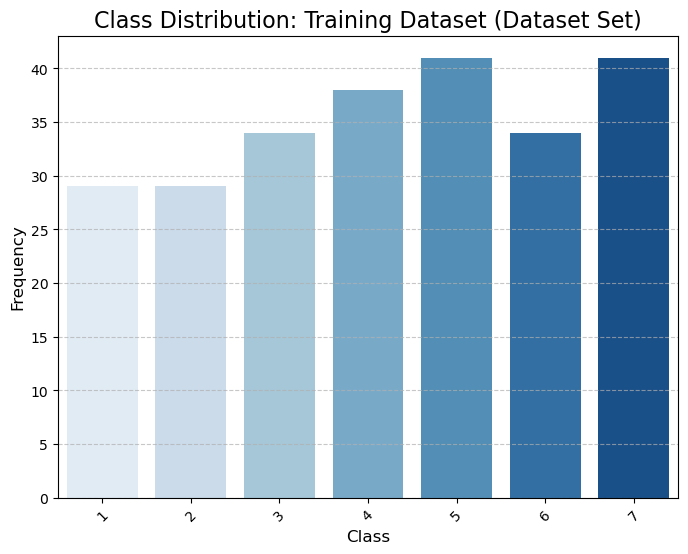

In [321]:
# generate boxplots for train and test datset distribution
plot_class_distribution(train_labels, title = "Class Distribution: Training Dataset")

C:\Users\Stacey\AppData\Local\Temp\ipykernel_19104\4254551826.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


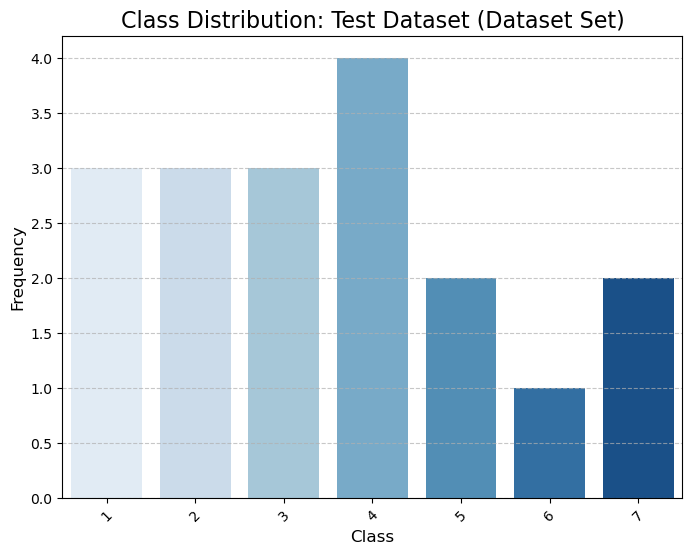

In [322]:
# generate boxplots for train and test datset distribution
plot_class_distribution(test_labels, title = "Class Distribution: Test Dataset")